# 1.- Descargar librerias

In [4]:
%pip install numpy pandas tensorflow matplotlib seaborn pillow scikit-learn gradio 


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


# 2.-Importar librerias 

In [5]:
import numpy as np
import pandas as pd
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import sys
import time
import shutil
import tensorflow.keras as keras
import tensorflow as tf
import re
import Augmentor
import seaborn as sns

from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras.models import load_model, Sequential
from keras.utils import to_categorical, load_img
from keras.layers import Lambda
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix,accuracy_score,f1_score
from keras.models import Sequential
from keras.layers import Dropout, Dense, Activation,GlobalAveragePooling2D,Dropout
import keras.applications.mobilenet_v2 as mobilenetv2
from playsound import playsound
import gradio as gr

ModuleNotFoundError: No module named 'Augmentor'

# 3.- Definir Contastantes

In [2]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3


base_path = "dataset-resized/"
categories = {0: 'battery', 1: 'biological', 2: 'cardboard', 3: 'glass', 4: 'metal', 5: 'paper', 6: 'plastic',7: 'trash'}

# 4.- Cargar datos

# 4.1 Balanceo de datos (se usa cuando las clases de imagenes se encuentran desbalanceadas)

### Limpiar las clases de ruta de imagenes que no tengan el formato RGB

In [3]:
ruta_base = 'dataset-resized'
def is_rgb_image(image_path):
    try:
        img = Image.open(image_path)
        return img.mode == 'RGB'
    except Exception as e:
        return False

def eliminar_imagenes_no_rgb(ruta_base):
    for image_class in os.listdir(ruta_base):
        class_path = os.path.join(ruta_base, image_class)
        if os.path.isdir(class_path):
            for image in os.listdir(class_path):
                image_path = os.path.join(class_path, image)
                if not is_rgb_image(image_path):
                    print('Eliminando imagen no RGB: {}'.format(image_path))
                    os.remove(image_path)
                    print('Imagen eliminada: {}'.format(image_path))

In [4]:
eliminar_imagenes_no_rgb(ruta_base)

### Utilitzar el Augmentor para balancear clases

In [28]:
import glob
#Se definen parámetros
target_images = 1441
#Se crea la función para aumentar imágenes en las clases necesarias
def augmented_data(class_name, num_required_img):
    class_path = os.path.join(base_path, class_name)

    num_existing = len(os.listdir(class_path))
    num_images_to_generate = num_required_img - num_existing

    p = Augmentor.Pipeline(source_directory=class_path)

    p.random_contrast(probability=0.5, min_factor=0.8, max_factor=1.2)
    p.random_brightness(probability=0.5, min_factor=0.8, max_factor=1.2)
    p.random_color(probability=0.5, min_factor=0.8, max_factor=1.2)
    p.flip_left_right(probability=0.5)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.zoom_random(probability=0.5, percentage_area=0.9)
    p.flip_top_bottom(probability=0.2)
    p.random_distortion(probability=0.5, grid_width=4, grid_height=4, magnitude=8)

    p.sample(num_images_to_generate)

    generated_images = glob.glob(os.path.join(class_path, "output", "*.*"))
    for i, image_path in enumerate(generated_images):
        new_name = "{}21_augmented_{:04d}.jpg".format(class_name, i + 1)
        os.rename(image_path, os.path.join(class_path, new_name))

# Se aplica la función a cada clase
augmented_data('battery', target_images)
augmented_data('biological', target_images)
augmented_data('cardboard', target_images)
augmented_data('metal', target_images)
augmented_data('paper', target_images)
augmented_data('plastic', target_images)
augmented_data('trash', target_images)


Initialised with 939 image(s) found.
Output directory set to dataset-resized/battery\output.

Processing <PIL.Image.Image image mode=RGB size=225x225 at 0x256F3A610F0>: 100%|██████████| 501/501 [00:00<00:00, 548.49 Samples/s]                  


Initialised with 985 image(s) found.
Output directory set to dataset-resized/biological\output.

Processing <PIL.Image.Image image mode=RGB size=225x225 at 0x256DC11A4D0>: 100%|██████████| 455/455 [00:00<00:00, 523.40 Samples/s]                  


Initialised with 891 image(s) found.
Output directory set to dataset-resized/cardboard\output.

Processing <PIL.Image.Image image mode=RGB size=512x384 at 0x256DC1F0670>: 100%|██████████| 549/549 [00:01<00:00, 353.20 Samples/s]                  


Initialised with 769 image(s) found.
Output directory set to dataset-resized/metal\output.

Processing <PIL.Image.Image image mode=RGB size=217x232 at 0x256F4009630>: 100%|██████████| 671/671 [00:01<00:00, 337.48 Samples/s]                  


Initialised with 1047 image(s) found.
Output directory set to dataset-resized/paper\output.

Processing <PIL.Image.Image image mode=RGB size=192x263 at 0x256F4216290>: 100%|██████████| 393/393 [00:01<00:00, 330.50 Samples/s]                  


Initialised with 865 image(s) found.
Output directory set to dataset-resized/plastic\output.

Processing <PIL.Image.Image image mode=RGB size=512x384 at 0x256DC147D90>: 100%|██████████| 575/575 [00:01<00:00, 317.87 Samples/s]                  


Initialised with 673 image(s) found.
Output directory set to dataset-resized/trash\output.

Processing <PIL.Image.Image image mode=RGB size=225x225 at 0x256F3EE19C0>: 100%|██████████| 767/767 [00:01<00:00, 527.94 Samples/s]                  


### Borra la carpeta output que se genera por el data Augmentor

In [29]:
class_names = [class_name for class_name in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, class_name))]

# Recorrer cada clase
for class_name in class_names:
    class_path = os.path.join(base_path, class_name)
    output_path = os.path.join(class_path, 'output')

    # Verificar si la carpeta 'output' existe en la clase
    if os.path.exists(output_path) and os.path.isdir(output_path):
        # Mover los archivos de 'output' a la carpeta de la clase
        for filename in os.listdir(output_path):
            src = os.path.join(output_path, filename)
            dst = os.path.join(class_path, filename)
            shutil.move(src, dst)

        # Eliminar la carpeta 'output' vacía
        os.rmdir(output_path)
        print(f'Carpeta "output" eliminada en la clase: {class_name}')

Carpeta "output" eliminada en la clase: battery
Carpeta "output" eliminada en la clase: biological
Carpeta "output" eliminada en la clase: cardboard
Carpeta "output" eliminada en la clase: metal
Carpeta "output" eliminada en la clase: paper
Carpeta "output" eliminada en la clase: plastic
Carpeta "output" eliminada en la clase: trash


# 4.2 Se convierte el Dataset a Dataframe

In [5]:
def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(lambda x: x[:re.search("\d",x).start()] + '/' + x)
    return df

# list conatining all the filenames in the dataset
filenames_list = []
# list to store the corresponding category, note that each folder of the dataset has one class of data
categories_list = []

for category in categories:
    filenames = os.listdir(base_path + categories[category])

    filenames_list = filenames_list  +filenames
    categories_list = categories_list + [category] * len(filenames)

df = pd.DataFrame({
    'filename': filenames_list,
    'category': categories_list
})

df = add_class_name_prefix(df, 'filename')
print(df)
# Shuffle the dataframe
df = df.sample(frac=1).reset_index(drop=True)

print('number of elements = ' , len(df))

                     filename  category
0        battery/battery1.jpg         0
1       battery/battery10.jpg         0
2      battery/battery100.jpg         0
3      battery/battery101.jpg         0
4      battery/battery102.jpg         0
...                       ...       ...
11516       trash/trash95.jpg         7
11517       trash/trash96.jpg         7
11518       trash/trash97.jpg         7
11519       trash/trash98.jpg         7
11520       trash/trash99.jpg         7

[11521 rows x 2 columns]
number of elements =  11521


In [6]:
df

,filename,category
0,trash/trash642.jpg,7
1,glass/glass609.jpg,3
2,battery/battery763.jpg,0
3,biological/biological377.jpg,1
4,glass/glass11210210_1.jpg,3
...,...,...
11516,paper/paper101.jpg,5
11517,biological/biological562.jpg,1
11518,plastic/plastic724.jpg,6
11519,paper/paper21_augmented_0144.jpg,5


# 4.1.- Visualizar imagenes de manera aleatoria

battery/battery21_augmented_0375.jpg


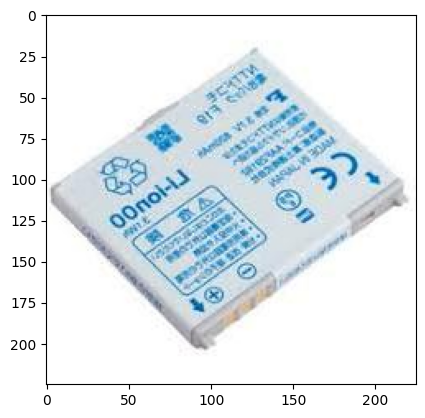

In [7]:
random_row = random.randint(0, len(df)-1)
sample = df.iloc[random_row]
randomimage = load_img(base_path +sample['filename'])
print(sample['filename'])
plt.imshow(randomimage)

# 4.2.- Visualizar cantidad de datos que contiene cada clase

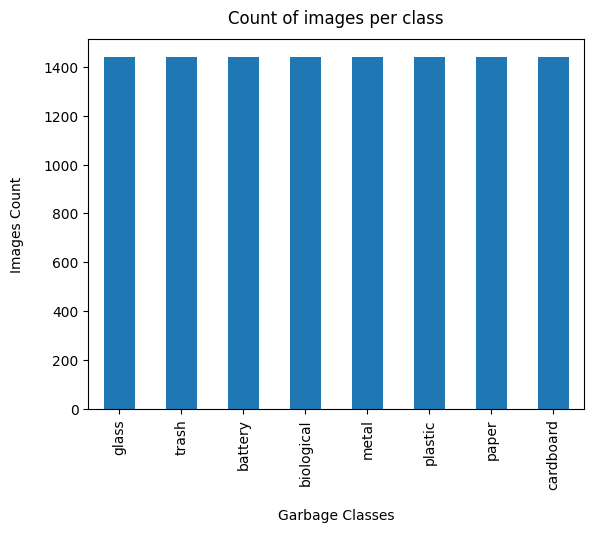

In [8]:
df_visualization = df.copy()
# Change the catgegories from numbers to names
df_visualization['category'] = df_visualization['category'].apply(lambda x:categories[x] )

df_visualization['category'].value_counts().plot.bar(x = 'count', y = 'category' )

plt.xlabel("Garbage Classes", labelpad=14)
plt.ylabel("Images Count", labelpad=14)
plt.title("Count of images per class", y=1.02);

In [9]:
df.groupby('category').count()

,filename
category,
0,1440
1,1440
2,1440
3,1441
4,1440
5,1440
6,1440
7,1440


# 5.- Seperar datos del Dataframe

In [10]:
df["category"] = df["category"].replace(categories)


train_df, validate_df = train_test_split(df, test_size=0.2, random_state=42)
validate_df, test_df = train_test_split(validate_df, test_size=0.5, random_state=42)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
print(train_df )
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
total_test = test_df.shape[0]
print('train size = ', total_train , 'validate size = ', total_validate, 'test size = ', total_test)

                                        filename    category
0               trash/trash21_augmented_0664.jpg       trash
1     biological/biological21_augmented_0190.jpg  biological
2                     cardboard/cardboard734.jpg   cardboard
3                   biological/biological404.jpg  biological
4                   biological/biological976.jpg  biological
...                                          ...         ...
9211                          metal/metal111.jpg       metal
9212        plastic/plastic21_augmented_0189.jpg     plastic
9213            metal/metal21_augmented_0078.jpg       metal
9214                          trash/trash581.jpg       trash
9215        battery/battery21_augmented_0460.jpg     battery

[9216 rows x 2 columns]
train size =  9216 validate size =  1152 test size =  1153


# 6.- Deep learning(Uso del modelo pre entrenado mobilenetv2)


In [11]:
mobilenetv2_layer = mobilenetv2.MobileNetV2(include_top = False, input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT,IMAGE_CHANNELS),
                    weights = 'imagenet')

# We don't want to train the imported weights
mobilenetv2_layer.trainable = False


model = Sequential()
model.add(keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))

#create a custom layer to apply the preprocessing
def mobilenetv2_preprocessing(img):
    return mobilenetv2.preprocess_input(img)

model.add(Lambda(mobilenetv2_preprocessing))

model.add(mobilenetv2_layer)
model.add(GlobalAveragePooling2D())
model.add(Dense(len(categories), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 8)                 10248     
                                                                 
Total params: 2,268,232
Trainable params: 10,248
Non-trainable params: 2,257,984
_________________________________________________________________


# 7.- Entrenamiento

# 7.1.- Aumento de datos(tecnica de entrenmiento)

In [13]:
batch_size=64

train_datagen = ImageDataGenerator(
    rotation_range=30,
    #shear_range=0.1,
    #zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip = True,
    #width_shift_range=0.2,
    #height_shift_range=0.2
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    base_path,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 9216 validated image filenames belonging to 8 classes.


In [14]:
validation_datagen = ImageDataGenerator(
    rotation_range=30,
    #shear_range=0.1,
    #zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip = True,
    #width_shift_range=0.2,
    #height_shift_range=0.2
)

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    base_path,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 1152 validated image filenames belonging to 8 classes.


In [15]:
test_datagen = ImageDataGenerator(
    rotation_range=30,
    #shear_range=0.1,
    #zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip = True,
    #width_shift_range=0.2,
    #height_shift_range=0.2
)
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    base_path,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False  # No necesitamos mezclar el conjunto de prueba para evaluarlo
)

Found 1153 validated image filenames belonging to 8 classes.


# 7.2 Early stopping (tecnica de entrenamiento de datos)

In [16]:
early_stop = EarlyStopping(patience = 2, verbose = 1, monitor='val_categorical_accuracy' , mode='max', min_delta=0.001, restore_best_weights = True)

callbacks = [early_stop]

# 7.3 Entrenar

In [17]:
EPOCHS = 50
history = model.fit_generator(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

C:\Users\hombr\AppData\Local\Temp\ipykernel_8300\3154049270.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/50
144/144 [==============================] - 216s 1s/step - loss: 0.7504 - categorical_accuracy: 0.7498 - val_loss: 0.4558 - val_categorical_accuracy: 0.8472
Epoch 2/50
144/144 [==============================] - 160s 1s/step - loss: 0.3857 - categorical_accuracy: 0.8741 - val_loss: 0.3695 - val_categorical_accuracy: 0.8672
Epoch 3/50
144/144 [==============================] - 162s 1s/step - loss: 0.3213 - categorical_accuracy: 0.8936 - val_loss: 0.3454 - val_categorical_accuracy: 0.8707
Epoch 4/50
144/144 [==============================] - 169s 1s/step - loss: 0.2850 - categorical_accuracy: 0.9040 - val_loss: 0.3200 - val_categorical_accuracy: 0.8872
Epoch 5/50
144/144 [==============================] - 157s 1s/step - loss: 0.2589 - categorical_accuracy: 0.9134 - val_loss: 0.3167 - val_categorical_accuracy: 0.8811
Epoch 6/50
144/144 [==============================] - 151s 1s/step - loss: 0.2456 - categorical_accuracy: 0.9159 - val_loss: 0.2926 - val_categorical_accuracy: 0.902

# 8.- Rendimiento

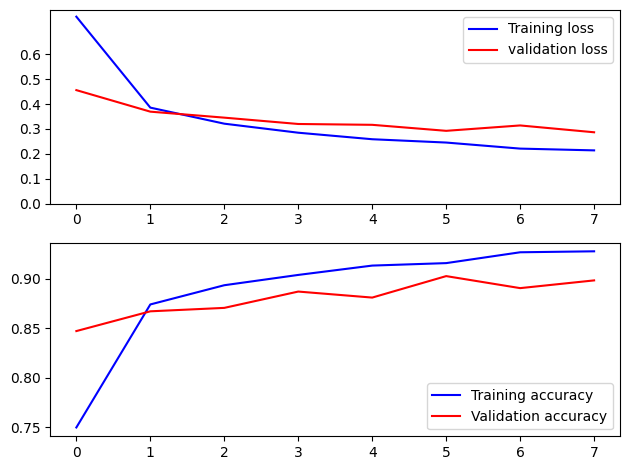

In [18]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_yticks(np.arange(0, 0.7, 0.1))
ax1.legend()

ax2.plot(history.history['categorical_accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_categorical_accuracy'], color='r',label="Validation accuracy")
ax2.legend()

legend = plt.legend(loc='best')
plt.tight_layout()
plt.show()

# 9.-Testeo

# 9.1 Matriz de Confusion

19/19 [==============================] - 23s 1s/step


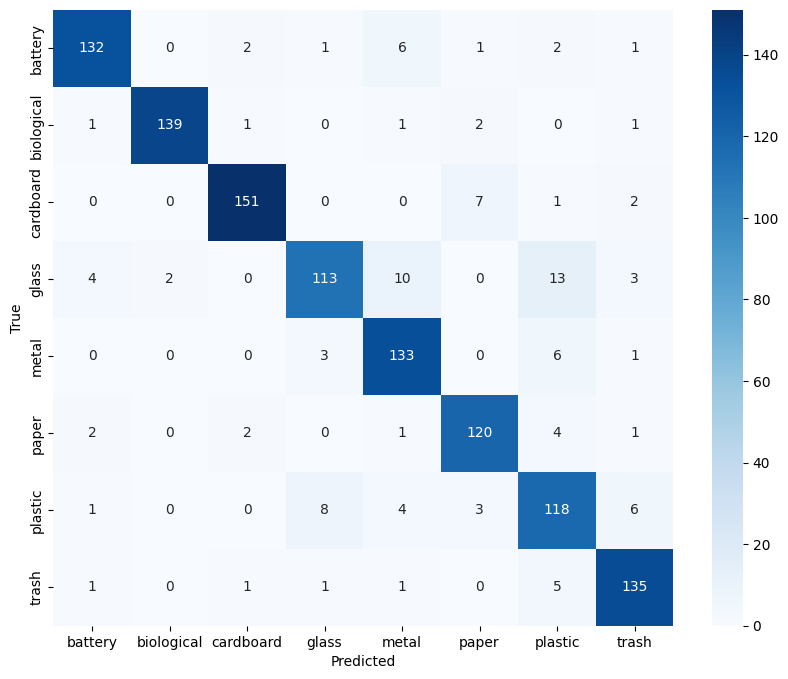

In [19]:


y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes  # Obtener las etiquetas verdaderas del generador de prueba

# Calcular la matriz de confusión
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

label_names = test_generator.class_indices.keys()



# Visualizar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# 9.2 Reporte de clasificacion

In [20]:
y_true = test_generator.classes
y_pred2 = y_pred_classes

In [21]:
report = classification_report(y_true, y_pred2)

print(report)

              precision    recall  f1-score   support

           0       0.94      0.91      0.92       145
           1       0.99      0.96      0.97       145
           2       0.96      0.94      0.95       161
           3       0.90      0.78      0.83       145
           4       0.85      0.93      0.89       143
           5       0.90      0.92      0.91       130
           6       0.79      0.84      0.82       140
           7       0.90      0.94      0.92       144

    accuracy                           0.90      1153
   macro avg       0.90      0.90      0.90      1153
weighted avg       0.90      0.90      0.90      1153



# 9.3 Precision

In [22]:
accuracy = accuracy_score(y_true, y_pred_classes)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9028620988725065


# 9.4 Perdida

In [23]:
loss = model.evaluate(test_generator, verbose=0)[0]
print(f'Loss: {loss}')

Loss: 0.28121837973594666


# 9.5 f1 Score

In [24]:
f1 = f1_score(y_true, y_pred_classes, average='weighted')
print(f'F1 Score: {f1}')

F1 Score: 0.9028888270345283


# 10.- Guardar Modelo

In [25]:
model.save("modelo.h5")

# 11.- Exportar el modelo en js

In [ ]:
!mkdir carpeta_salida

Ya existe el subdirectorio o el archivo carpeta_salida.


In [52]:
!tensorflowjs_converter --input_format keras modelo.h5 carpeta_salida

# 12.- Diseño Interfaz

In [6]:
model = tf.keras.models.load_model("modelo.h5")

In [7]:
categories_traduccion = {0: 'Bateria', 1: 'Biologico', 2: 'carton', 3: 'vidrio', 4: 'metal', 5: 'papel', 6: 'plastico',7: 'basura'}

In [25]:
# Inicializa pygame para la reproducción de audio
def clasificar(img):
    img_array = np.array(img)
    img_copy = np.copy(img_array)
    img_resized = Image.fromarray(img_copy).resize((224, 224))
    img_resized_array = np.array(img_resized)
    img_reshaped = img_resized_array.reshape(1, 224, 224, 3)
    pred = model.predict(img_reshaped)[0]
    predictions = {categories_traduccion[i]: float(pred[i]) for i in range(8)}
    pclave_maximo_valor = max(predictions, key=predictions.get)

    diccionario_ordenado = dict(sorted(predictions.items(), key=lambda item: item[1], reverse=True))
    print(pclave_maximo_valor)
    print(diccionario_ordenado )    
    
    return predictions

interfaz = gr.Interface(
    fn=clasificar,
    inputs=gr.components.Image(sources='upload', label='Captura desde cámara'),
    outputs=gr.components.Label(num_top_classes=7)
)

interfaz.launch(debug=False, share=True)

Running on local URL:  http://127.0.0.1:7876

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.
